## Preliminary

In [263]:
tree_train.homo.std(), tree_train.homo.mean()

(0.5923692933940143, -6.547214124282521)

In [189]:
from zipfile import ZipFile
import os
from os.path import basename
# create a ZipFile object

dirName = 'Mols'
with ZipFile('Mols.zip', 'w') as zipObj:
   # Iterate over all the files in directory
    for folderName, subfolders, filenames in os.walk(dirName):
        for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))

In [ ]:
from zipfile import ZipFile

zipObj = ZipFile('sample.zip', 'w')

for i in 
zipObj.write('sample_file.csv')
zipObj.write('test_1.log')
zipObj.write('test_2.log')

zipObj.close()

In [291]:
vocab.size()

2327

In [80]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
from CGRtools import smiles
from optparse import OptionParser
from collections import deque
from IPython.display import clear_output
from Levenshtein import distance as Lev
from math import pi
import rdkit
from rdkit import Chem

    
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [2]:
import math, random, sys
sys.path.append('/workspace/icml18-jtnn_original')
from jtnn import *

from warnings import filterwarnings
filterwarnings("ignore")

### Functions

In [4]:
def latent_space_descent(variables, target, regressor, loss, opt, n_steps = 1):
    regressor.train()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, target)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()

def latent_space_descent_two_proprieties(variables, target, regression, loss, opt, n_steps = 1):
    regressor.eval()
    props = (torch.ones(variables.size()[0], 1)*target).cuda()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, props)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()
        
def latent_space_descent_m(variables, target, regression, loss, opt, n_steps = 1):
    regressor.train()
    props = (torch.ones(variables.size()[0], target.shape[0])*target).cuda()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, props)
        wloss = wloss.sum(dim=1).mean(dim=0)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()
        
def init_latent_vector(size, example=None):
    if example is not None:
        return torch.tensor(example + torch.rand(size, device="cuda"), requires_grad=True)

    else:
        return torch.rand(size, device="cuda", requires_grad=True)

In [342]:
def clean(smls):
    try:
        mol = smiles(smls)
        mol.clean_stereo()
        mol.canonicalize()
        return mol.__str__()
    except:
        return None

In [6]:
def get_metrics(model, molecules, ss, target_molecule, target_g):
    """
    Add best cosine similarity/ smallest L2 norm to hidden vectors as a metric 
    Add distance between vocabularies 
    Add cosine similarity of tree
    Add cosine similarity of molecules
    Add L2 distance for tree
    Add L2 distance for molecules
    Add Levenshtain distance
    """
    
    L2_best = ((molecules - target_molecule)**2).sum(dim=1).min().item()
    Cosine_best = torch.nn.functional.cosine_similarity(target_molecule, molecules).max().item()
    
    tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
    tree_vec_target, mol_vec_target = torch.split(target_molecule, target_molecule.size()[1]//2, 1)
    
    L2_best_tree = ((tree_vec - tree_vec_target)**2).sum(dim=1).min().item()
    Cosine_best_tree = torch.nn.functional.cosine_similarity(tree_vec, tree_vec_target).max().item()
    
    L2_best_mol = ((mol_vec - mol_vec_target)**2).sum(dim=1).min().item()
    Cosine_best_mol = torch.nn.functional.cosine_similarity(mol_vec, mol_vec_target).max().item()
    
    binary_smiles = []
    for s in ss:
        try:
            mol = MolTree(s)
            binary_h = [0]*vocab.size()
            for c in mol.nodes:
                binary_h[vocab.get_index(c.smiles)] = 1

            binary_smiles.append(binary_h)
        except BaseException:
            continue

    binary_smiles = torch.tensor(binary_smiles, device = torch.device("cuda"))
    
    target = [[0]*vocab.size()]
    
    for n in target_g.nodes:
        try:
            target[0][vocab.get_index(n.smiles)] = 1
        except KeyError:
            continue
        
    target = torch.tensor(target, device = torch.device("cuda"))
    dice = (2*(binary_smiles*target).sum(1)/(binary_smiles.sum(1) + target.sum(1))).max().item()
    tanimoto = ((binary_smiles*target).sum(1)/(((binary_smiles + target) > 0).sum(1))).max().item()
    lev = np.min([Lev(target_g.smiles, s) for s in ss])
    
    _, tree_vec_target, mol_vec_target = model.encode([tree_t])
    tree_mean = model.T_mean(tree_vec_target)
    tree_var = torch.exp(-torch.abs(model.T_var(tree_vec_target)))
    mol_mean = model.G_mean(mol_vec_target)
    mol_var = torch.exp(-torch.abs(model.G_var(mol_vec_target)))

    mu, sigma = torch.cat([tree_mean,mol_mean], dim=1), torch.cat([tree_var,mol_var], dim=1)
    
    H = 1/torch.sqrt(2*pi*sigma)
    h = torch.exp(-(mu - molecules)**2/(2*sigma))/torch.sqrt(2*pi*sigma)
    slutskiy = (h/H).mean(dim=1).max().item()
    
    return [L2_best, Cosine_best, L2_best_tree, Cosine_best_tree, L2_best_mol, Cosine_best_mol, dice, tanimoto, lev, slutskiy]

In [52]:
def double_descent(variables,
                   target,
                   search_model,
                   search_regression,
                   regression_model,
                   regression_regressor,
                   loss,
                   lr,
                   n_steps = 1,
                   n_iter = 1,
                   verbose=True):
    
    search_model.eval()
    search_regression.eval()
    regression_model.eval()
    regression_regressor.eval()
    try:
        
        if verbose:
            pbar = tqdm(range(n_iter))
            
        else:
            pbar = range(n_iter)
            
        for j in pbar:
            tree_vec, mol_vec = torch.split(variables, variables.size()[1]//2, 1)
            s = []

            for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
                s_string = search_model.decode(tree[None, :],mol[None, :], False)

                if s_string is not None:
                    _s = smiles(search_model.decode(tree[None, :],mol[None, :], False))
                    _s.clean_stereo()
                    _s.canonicalize()
                    s.append(_s.__str__())

            s = list(filter(lambda x: Chem.MolFromSmiles(x) is not None, set(s)))
            coeffs = regression_regressor(regression_model.encode_latent_mean(s))
            idxes = torch.abs(coeffs - target).argsort(dim=0).flatten()
            variables = variables[idxes[:10]].repeat((10, 1))
            variables = (variables.detach() + torch.rand([variables.shape[0], 256], device="cuda"))
            variables.requires_grad = True 
            optimizer = optim.Adam([variables], lr=lr)

            regressor.train()
            props = (torch.ones(variables.size()[0], 1, device="cuda")*target).cuda()
            for i in range(n_steps):
                search_regression.zero_grad()
                optimizer.zero_grad()

                prediction = search_regressor(variables)
                wloss = loss(prediction, props)
                wloss.backward()
                optimizer.step()
        return variables
    
    except:
        return variables

### Data

In [7]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)
scale = 27.21

columns = ["tree", "homo", "lumo", "gap"]

data = pd.read_csv("data/merged/all.txt")

df_train = pd.read_csv("data/merged/csv/train_reg.csv")
df_test = pd.read_csv("data/merged/csv/test_reg.csv")
df_val = pd.read_csv("data/merged/csv/val_reg.csv")

df_train.homo = df_train.homo*scale
df_train.lumo = df_train.lumo*scale
df_train.gap = df_train.gap*scale

df_test.homo = df_test.homo*scale
df_test.lumo = df_test.lumo*scale
df_test.gap = df_test.gap*scale

df_val.homo = df_val.homo*scale
df_val.lumo = df_val.lumo*scale
df_val.gap = df_val.gap*scale

### Tree creation

In [26]:
df = df_train

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])

tree_train = pd.DataFrame(lines, columns = columns)

In [28]:
df = df_test

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])
    
tree_test = pd.DataFrame(lines, columns = columns)

100% 5000/5000 [14:12<00:00,  5.86it/s]  


In [29]:
df = df_val

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])
    
tree_val = pd.DataFrame(lines, columns = columns)

100% 2500/2500 [06:17<00:00,  6.62it/s]


### Model loading

In [30]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

hidden_size = 612
latent_size = 256
depth = 3
stereo = True
batch_size = 8192
random_state = 42

modelvae_path = 'reg_model/merged_qdb9_256_612_homo/decoder_bigger_batch/model'
regressorvae_path = 'reg_model/merged_qdb9_256_612_homo/model_regression'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

model.load_state_dict(torch.load(modelvae_path))
regressor.load_state_dict(torch.load(regressorvae_path))

model = model.cuda()
regressor = regressor.cuda()

### Embedding extraction

In [31]:
X_train = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_train = pd.DataFrame(columns=["homo", "lumo", "gap"])

df = tree_train
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_train = X_train.append(pd.DataFrame(features.cpu().numpy(), columns=X_train.columns),ignore_index=True)
        y_train = y_train.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 15/15 [02:55<00:00, 11.71s/it]


In [32]:
X_test = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_test = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_test
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_test = X_test.append(pd.DataFrame(features.cpu().numpy(), columns=X_test.columns),ignore_index=True)
        y_test = y_test.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 1/1 [00:06<00:00,  6.46s/it]


In [33]:
X_val = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_val = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_val
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_val = X_val.append(pd.DataFrame(features.cpu().numpy(), columns=X_val.columns),ignore_index=True)
        y_val = y_val.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 1/1 [00:03<00:00,  3.18s/it]


In [34]:
train_smiles_set = set(tree_train.tree.apply(lambda x: clean(x.smiles)))
test_smiles_set = set(tree_test.tree.apply(lambda x: clean(x.smiles)))
val_smiles_set = set(tree_val.tree.apply(lambda x: clean(x.smiles)))

In [35]:
tree_val.index = tree_val.tree.apply(lambda x: clean(x.smiles))

In [36]:
data_m = ["C1COC(O1)=O", "C1=CC(C)C=CC(=O)C1", "C1C=CC=CC(CC)=C1", "N1=C(N=C(OC1=O)C)F", "c1c2c[nH]cc2ncc1"]
tree_m = tree_val.loc[data_m]

In [37]:
lines = []
for line in ["Molecule c1c2ccccc2co1, predicted value: -5.757090091705322, real value: -5.25, difference: 0.5070900917053223",
"Molecule c1c2c3ccccc3c4cocc4c2ccc1, predicted value: -5.630673885345459, real value: -5.51, difference: 0.1206738853454592",
"Molecule c12c3c4cccc3ccc1cccc2c5cocc45, predicted value: -5.522493839263916, real value: -5.54, difference: 0.01750616073608402",
"Molecule c1cc2cc3c(cc2cc1)ccc4c3coc4, predicted value: -4.917288303375244, real value: -5.39, difference: 0.47271169662475554",
"Molecule c12ccccc1ccc3c2coc3, predicted value: -5.673248767852783, real value: -5.39, difference: 0.2832487678527835",
"Molecule c1cccc2c1c3c(ccc4cocc34)cc2, predicted value: -5.381400108337402, real value: -5.27, difference: 0.11140010833740277",
"Molecule c1c2c(c3c(cccc3)c1)ccc4cocc24, predicted value: -6.051238059997559, real value: -5.22, difference: 0.8312380599975588",
"Molecule c12cocc1cc3ccc4cccc5ccc2c3c45, predicted value: -5.743382453918457, real value: -4.86, difference: 0.8833824539184567",
"Molecule c12ccc3c(cc4cocc4c3)c1cccc2, predicted value: -5.641488552093506, real value: -4.91, difference: 0.7314885520935057",
"Molecule c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2, predicted value: -5.2047438621521, real value: -4.84, difference: 0.36474386215209975",
"Molecule c12c(cccc1)cc3cocc3c2, predicted value: -5.534309387207031, real value: -4.78, difference: 0.754309387207031",
"Molecule c12c(cc3c(cccc3)c1)cc4c(c2)coc4, predicted value: -6.212608337402344, real value: -4.48, difference: 1.7326083374023433"]:

    line = line.split(',')
    mol_tree = MolTree(line[0].split(' ')[1])
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, float(line[2].split(":")[1]), "-", "-"])
    
tree_n = pd.DataFrame(lines, columns = columns)

In [38]:
X_m = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_m = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_m
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_m = X_m.append(pd.DataFrame(features.cpu().numpy(), columns=X_m.columns),ignore_index=True)
        y_m = y_m.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 1/1 [00:00<00:00, 45.08it/s]


In [39]:
X_n = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_n = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_n
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_n = X_n.append(pd.DataFrame(features.cpu().numpy(), columns=X_n.columns),ignore_index=True)
        y_n = y_n.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 1/1 [00:00<00:00, 29.52it/s]


### 1

In [40]:
k_processed = 0
trees = tree_m
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_m
metrics_path = "rec_metrics/metric_m_1.csv"
error_path = "rec_metrics/error_m_1.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [100, 256]
        molecules = torch.rand(size, device=torch.device("cuda"))*torch.tensor(X_val.std(), device=torch.device("cuda")) + torch.tensor(X_val.mean(), device=torch.device("cuda")) 
        molecules.requires_grad = True
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((100, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, 100)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_m_1 = map
metrics_m_1 = metrics

In [41]:
k_processed = 0
trees = tree_n
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_n
metrics_path = "rec_metrics/metric_n_1.csv"
error_path = "rec_metrics/error_n_1.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [100, 256]
        molecules = torch.rand(size, device=torch.device("cuda"))*torch.tensor(X_val.std(), device=torch.device("cuda")) + torch.tensor(X_val.mean(), device=torch.device("cuda")) 
        molecules.requires_grad = True
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((100, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, 100)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_n_1 = map
metrics_n_1 = metrics

### 2

In [42]:
k_processed = 0
trees = tree_m
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_m
metrics_path = "rec_metrics/metric_m_2.csv"
error_path = "rec_metrics/error_m_2.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = (((tree_train.homo - target)**2)).argmin()
        
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((100, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, 100)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_m_2 = map
metrics_m_2 = metrics

In [43]:
k_processed = 0
trees = tree_n
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_n
metrics_path = "rec_metrics/metric_n_2.csv"
error_path = "rec_metrics/error_n_2.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = (((tree_train.homo - target)**2)).argmin()
        
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((100, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, 100)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_n_2 = map
metrics_n_2 = metrics

### 3

In [44]:
k_processed = 0
trees = tree_m
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_m
metrics_path = "rec_metrics/metric_m_3.csv"
error_path = "rec_metrics/error_m_3.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = ((X_train - X.iloc[k])**2).sum(axis=1).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((size[0]+1, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, n_steps)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_m_3 = map
metrics_m_3 = metrics

In [45]:
k_processed = 0
trees = tree_n
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_n
metrics_path = "rec_metrics/metric_n_3.csv"
error_path = "rec_metrics/error_n_3.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = ((X_train - X.iloc[k])**2).sum(axis=1).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((size[0]+1, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, n_steps)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_n_3 = map
metrics_n_3 = metrics

### 4

In [53]:
k_processed = 0
trees = tree_m
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_m
metrics_path = "rec_metrics/metric_m_4.csv"
error_path = "rec_metrics/error_m_4.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [100, 256]
        molecules = torch.rand(size, device=torch.device("cuda"))*torch.tensor(X_val.std(), device=torch.device("cuda")) + torch.tensor(X_val.mean(), device=torch.device("cuda")) 
        molecules.requires_grad = True
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_m_4 = map
metrics_m_4 = metrics

In [54]:
k_processed = 0
trees = tree_n
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_n
metrics_path = "rec_metrics/metric_n_4.csv"
error_path = "rec_metrics/error_n_4.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [100, 256]
        molecules = torch.rand(size, device=torch.device("cuda"))*torch.tensor(X_val.std(), device=torch.device("cuda")) + torch.tensor(X_val.mean(), device=torch.device("cuda")) 
        molecules.requires_grad = True
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_n_4 = map
metrics_n_4 = metrics

### 5

In [55]:
k_processed = 0
trees = tree_m
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_m
metrics_path = "rec_metrics/metric_m_5.csv"
error_path = "rec_metrics/error_m_5.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = (((tree_train.homo - target)**2)).argmin()
        
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True

        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_m_5 = map
metrics_m_5 = metrics

In [56]:
k_processed = 0
trees = tree_n
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_n
metrics_path = "rec_metrics/metric_n_5.csv"
error_path = "rec_metrics/error_n_5.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = (((tree_train.homo - target)**2)).argmin()
        
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True

        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_n_5 = map
metrics_n_5 = metrics

### 6

In [57]:
k_processed = 0
trees = tree_m
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_m
metrics_path = "rec_metrics/metric_m_6.csv"
error_path = "rec_metrics/error_m_6.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = ((X_train - X.iloc[k])**2).sum(axis=1).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_m_6 = map
metrics_m_6 = metrics

In [58]:
k_processed = 0
trees = tree_n
map = {}
metrics = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])
X = X_n
metrics_path = "rec_metrics/metric_n_6.csv"
error_path = "rec_metrics/error_n_6.txt"

try:
    pbar = tqdm(range(trees.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = trees.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = ((X_train - X.iloc[k])**2).sum(axis=1).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        df_line = get_metrics(model, molecules, s, torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics = metrics.append(pd.Series(df_line, index = metrics.columns), ignore_index=True)
        metrics.to_csv(metrics_path)

        map[k] = [s, molecules.detach().cpu().clone(), torch.tensor(X.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
        
except BaseException as e:
    with open(error_path, "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())
        
clear_output()
map_n_6 = map
metrics_n_6 = metrics

In [138]:
def save_fig_stats(path, map, name):
    if not os.path.isdir(path):
        os.mkdir(path)
        
    if not os.path.isdir(path+"/"+name):
        os.mkdir(path+"/"+name)  
            
    for i, (key, mapping) in enumerate(map.items()):
        if not os.path.isdir(path+"/"+name+"/mol_"+str(i)):
            os.mkdir(path+"/"+name+"/mol_"+str(i))  
        
        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mapping[3].smiles))
        fig = plt.figure(figsize=(15, 5))
        plt.title(mapping[3].smiles)
        plt.imshow(img)
        plt.axis("off")
        plt.savefig(path+"/"+name+"/mol_"+str(i)+'/'+'main_{}.pdf'.format(i))
        plt.close(fig)
        
        for j, (sub_figure) in enumerate(mapping[0]):
            flag = ''
            if mapping[3].smiles == sub_figure:
                flag = '*'
            img = Chem.Draw.MolToImage(Chem.MolFromSmiles(sub_figure))
            fig = plt.figure(figsize=(15, 5))
            plt.title(sub_figure)
            plt.imshow(img)
            plt.axis("off")
            plt.savefig(path+"/"+name+"/mol_"+str(i)+'/'+'fig_{}'.format(j)+flag+'.pdf')
            plt.close(fig)
            
    return

In [181]:
for j, _map in enumerate([map_n_1, map_n_2, map_n_3, map_n_4, map_n_5, map_n_6]):
    print("Method number: {}".format(1+j))
    success = 0
    success_list = []
    for i in range(len(_map)):
        if _map[i][3].smiles in _map[i][0]:
            success += 1
            success_list.append(i)
    print("Success rate: {}/{}, Indexes: ".format(success, len(_map)), end=' ')
    for idx in success_list:
        print(" {}".format(idx), end=" ")
    print()
    print()

Method number: 1
Success rate: 0/12, Indexes:  

Method number: 2
Success rate: 0/12, Indexes:  

Method number: 3
Success rate: 1/12, Indexes:   0 

Method number: 4
Success rate: 0/12, Indexes:  

Method number: 5
Success rate: 0/12, Indexes:  

Method number: 6
Success rate: 0/12, Indexes:  



In [183]:
for j, _map in enumerate([map_m_1, map_m_2, map_m_3, map_m_4, map_m_5, map_m_6]):
    print("Method number: {}".format(1+j))
    success = 0
    success_list = []
    for i in range(len(_map)):
        if _map[i][3].smiles in _map[i][0]:
            success += 1
            success_list.append(i)
    print("Success rate: {}/{}, Indexes: ".format(success, len(_map)), end=' ')
    for idx in success_list:
        print(" {}".format(idx), end=" ")
    print()
    print()

Method number: 1
Success rate: 0/5, Indexes:  

Method number: 2
Success rate: 0/5, Indexes:  

Method number: 3
Success rate: 5/5, Indexes:   0  1  2  3  4 

Method number: 4
Success rate: 0/5, Indexes:  

Method number: 5
Success rate: 0/5, Indexes:  

Method number: 6
Success rate: 0/5, Indexes:  



In [141]:
save_fig_stats("mol_m", map_m_1, "1")
save_fig_stats("mol_m", map_m_2, "2")
save_fig_stats("mol_m", map_m_3, "3")
save_fig_stats("mol_m", map_m_4, "4")
save_fig_stats("mol_m", map_m_5, "5")
save_fig_stats("mol_m", map_m_6, "6")

save_fig_stats("mol_n", map_n_1, "1")
save_fig_stats("mol_n", map_n_2, "2")
save_fig_stats("mol_n", map_n_3, "3")
save_fig_stats("mol_n", map_n_4, "4")
save_fig_stats("mol_n", map_n_5, "5")
save_fig_stats("mol_n", map_n_6, "6")

### New Data

In [310]:
from ogb.lsc import PCQM4MDataset
ROOT = '.'
dataset = PCQM4MDataset(root = ROOT, only_smiles = True)

The PCQM4M has been deprecated. The leaderboard is no longer maintained.
Please use PCQM4Mv2 instead.
('[O-]C(=O)CC(C[N+](C)(C)C)OC(=O)C', nan)


In [ ]:
PCQM4M = []
for i in range(len(dataset)):
    if dataset[i][1] is not None:
        PCQM4M.append(dataset[i])
        
PCQM4M = pd.DataFrame(PCQM4M, columns=["Mol", "gap"])
PCQM4M_set = set(PCQM4M.Mol)
PCQM4M_set_clean = set([clean(mol) for mol in PCQM4M_set])

In [ ]:
PCQM4M["Mol_C"] = PCQM4M.Mol.apply(lambda x: clean(x))

In [383]:
PCQM = PCQM4M.dropna()
PCQM = PCQM.drop_duplicates('Mol', keep='first')
PCQM = PCQM.drop_duplicates('Mol_C', keep='first')
PCQM = PCQM.set_index('Mol_C')

In [404]:
def lambda_PCQM(mol):
    if mol in PCQM.index:
        return PCQM.loc[mol].Homo
    else:
        return None

## Homo Regression

In [408]:
train_set = set(tree_train.tree.apply(lambda x: x.smiles))

In [409]:
mols_problematic = [list(map_m_3[0][0])[i] for i in [10, 17, 41]]
mols_real = [list(map_m_3[0][0])[i] for i in [14, 25, 29, 4, 9]]
mols_virtual = [list(map_m_3[0][0])[i] for i in [1, 27, 7, 8]]

homo_mols_problematic = regressor(model.encode_latent_mean(mols_problematic)).flatten().tolist()
homo_mols_real = regressor(model.encode_latent_mean(mols_real)).flatten().tolist()
homo_mols_virtual = regressor(model.encode_latent_mean(mols_virtual)).flatten().tolist()

base_mol = [map_m_3[0][3].smiles]
homo_base_mol = [tree_m.iloc[0].homo]

In [410]:
res_data = zip(base_mol + mols_problematic + mols_real + mols_virtual, homo_mols_problematic + homo_mols_real + homo_mols_virtual + homo_base_mol)
res = pd.DataFrame(res_data, columns=["Mol", "Homo"])

In [411]:
res["In_Train"] = res.Mol.apply(lambda x: x in train_set)
res["In_PCQM"] = res.Mol.apply(lambda x: x in PCQM4M_set)
res["In_PCQM_Clean"] = res.Mol.apply(lambda x: x in PCQM4M_set_clean)
res["Gap_PCQM"] = res.Mol.apply(lambda x: lambda_PCQM(x))

In [412]:
res

,Mol,Homo,In_Train,In_PCQM,In_PCQM_Clean,Homo_PCQM
0,C1COC(O1)=O,-6.805753,False,False,True,NaN
1,OCC1(CC1NC(C2[NH2+]CCCC2)=O)C,-6.639012,False,False,False,NaN
2,O=C(NC1C(C1)(C)C[NH3+])C,-6.864084,False,False,False,NaN
3,C1C(O)CC(C([O-])=O)(CC1)C,-6.611206,False,False,False,NaN
4,C1C(C(=O)C)CCO1,-7.562531,False,False,True,6.179706
5,O=C(C)C(OC)C#N,-8.061135,False,False,True,5.659968
6,C1CCCCC1C(C#N)C,-6.861677,False,False,True,9.211054
7,OCC1C(C)C1,-6.248363,False,False,True,7.145710
8,c1cc(ccc1O)CNC(=O)C2(CCCCC2)C,-5.754284,False,False,False,NaN
9,O1c2c(c(c(cc2)C)OC)CCCC1,-6.830246,False,False,False,NaN


In [358]:
mols_problematic = [list(map_m_3[1][0])[i] for i in [9, 8, 7, 5, 23, 19, 17, 15, 14, 12, 11, 10]]
mols_real = [list(map_m_3[1][0])[i] for i in [4, 3, 16, 1, 0]]
mols_virtual = [list(map_m_3[1][0])[i] for i in [13]]

homo_mols_problematic = regressor(model.encode_latent_mean(mols_problematic)).flatten().tolist()
homo_mols_real = regressor(model.encode_latent_mean(mols_real)).flatten().tolist()
homo_mols_virtual = regressor(model.encode_latent_mean(mols_virtual)).flatten().tolist()

base_mol = [map_m_3[1][3].smiles]
homo_base_mol = [tree_m.iloc[1].homo]

In [448]:
[map_n_3[i][3].smiles in map_n_3[i][0] for i in range(5)], [map_m_3[i][3].smiles in map_m_3[i][0] for i in range(5)]

([True, False, False, False, False], [True, True, True, True, True])

In [359]:
res_data = zip(base_mol + mols_problematic + mols_real + mols_virtual, homo_mols_problematic + homo_mols_real + homo_mols_virtual + homo_base_mol)
res = pd.DataFrame(res_data, columns=["Mol", "Homo"])

In [406]:
res["In_Train"] = res.Mol.apply(lambda x: x in train_set)
res["In_PCQM"] = res.Mol.apply(lambda x: x in PCQM4M_set)
res["In_PCQM_Clean"] = res.Mol.apply(lambda x: x in PCQM4M_set_clean)
res["Homo_PCQM"] = res.Mol.apply(lambda x: lambda_PCQM(x))

### Guided Molecule Generation

In [510]:
def get_similar(model, molecule, regressor, properity):
    tree =  MolTree(molecule)
    tree.recover()
    tree.assemble()
    
    lr_mol, n_steps = 0.0001, 150
    loss = nn.MSELoss(reduction="mean")
    tree.smiles = clean(tree.smiles)
        
    target = [properity]
    size = [99, 256]

    idx = ((X_train - X.iloc[k])**2).sum(axis=1).argmin()
    multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
    molecules = torch.tensor(model.encode_latent_mean([molecule])*multiplier, device=torch.device("cuda"))
    molecules.requires_grad = True

    target = torch.FloatTensor(target)
    target = target.to(torch.device("cuda"))
    optimizer = optim.Adam([molecules], lr=lr_mol)

    props = latent_space_descent(molecules, target.repeat((size[0]+1, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, n_steps)

    clear_output(wait=True)        
    tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

    s = set()

    for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
        _s = model.decode(tree[None, :],mol[None, :], False)
        if _s is not None:
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.add(_s.__str__())
    return s

In [494]:
def show_molecule(mol):
    plt.figure(figsize=(18, 6))
    img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mol))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [519]:
df_test.homo.head()

0   -6.802500
1   -5.937222
2   -7.047390
3   -6.217485
4   -7.278675
Name: homo, dtype: float64

In [517]:
(df_test.smiles == "CC1C(O)CC1C1CC1").sum()

1

In [ ]:
list_outputs = []

In [533]:
#outputs = get_similar(model, "CC1C(O)CC1C1CC1", regressor, -5.937222)
list_outputs = list(outputs)
output_coeffs = regressor(model.encode_latent_mean(list_outputs))
output_best = torch.argsort(torch.abs(output_coeffs.flatten() + 5.937222))[-10:]

In [539]:
torch.sort(torch.abs(output_coeffs.flatten() + 5.937222))[0][:10]

tensor([0.0009, 0.0255, 0.0567, 0.0588, 0.1022, 0.1040, 0.1256, 0.1672, 0.1780,
        0.1835], device='cuda:0', grad_fn=<SliceBackward>)

In [548]:
coefs, idxes = torch.sort(torch.abs(output_coeffs.flatten() + 5.937222))
coefs = coefs[:10]
idxes = idxes[:10]

In [553]:
coefs[[1, 2, 6]] - 5.937222

tensor([-5.9117, -5.8806, -5.8116], device='cuda:0', grad_fn=<SubBackward0>)

In [549]:
coefs - 5.937222

tensor([-5.9363, -5.9117, -5.8806, -5.8785, -5.8350, -5.8333, -5.8116, -5.7700,
        -5.7592, -5.7538], device='cuda:0', grad_fn=<SubBackward0>)

In [559]:
list_outputs[idxes[6]], coefs[6] - 5.937222

('OCC1(CC1N2CC=CC(=O)C2)CC',
 tensor(-5.8116, device='cuda:0', grad_fn=<SubBackward0>))

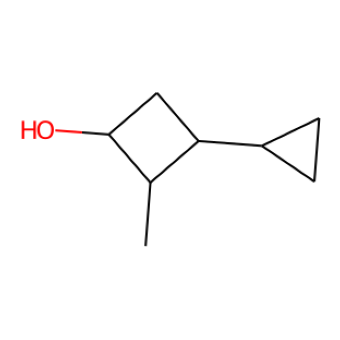

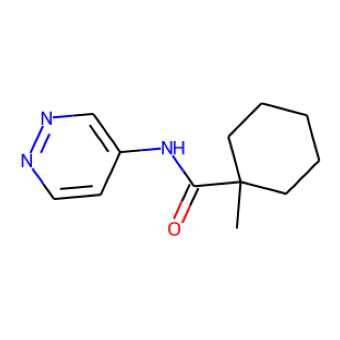

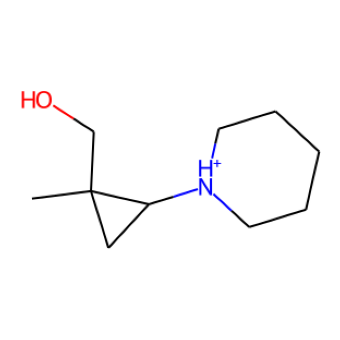

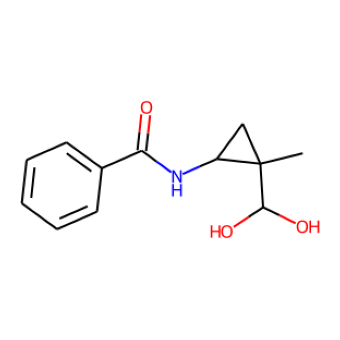

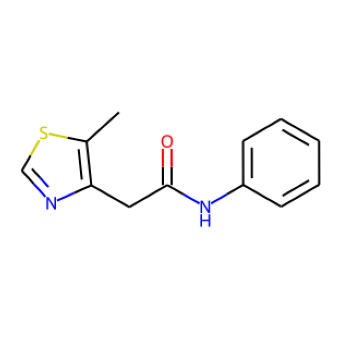

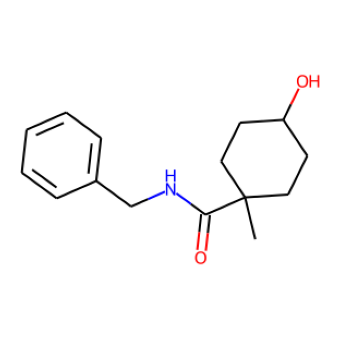

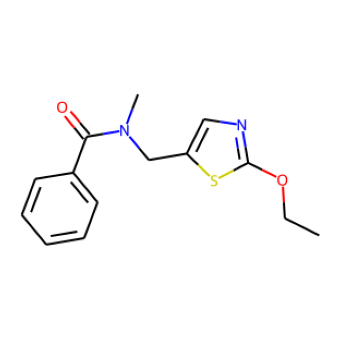

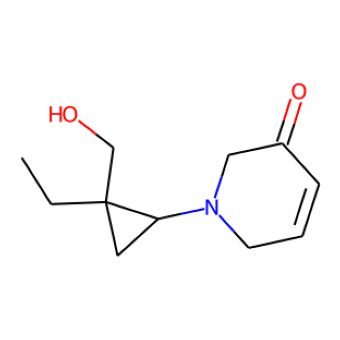

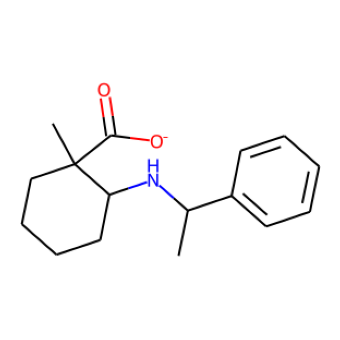

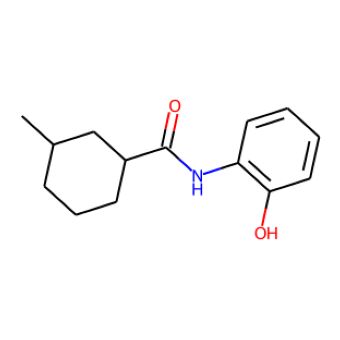

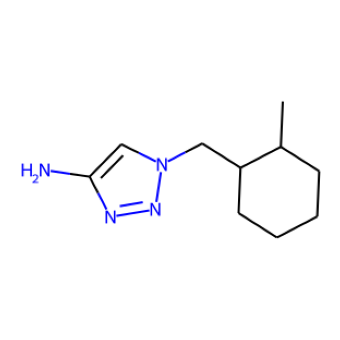

In [551]:
show_molecule("CC1C(O)CC1C1CC1")
for i in idxes:
    show_molecule(list_outputs[i])

In [ ]:
outputs = get_similar(model, "CC1C(O)CC1C1CC1", regressor, -5.937222)
list_outputs = list(outputs[0])
output_coeffs = regressor(model.encode_latent_mean(list_outputs))
output_best = torch.argsort(output_coeffs.flatten() - 5.937222)[-10:]

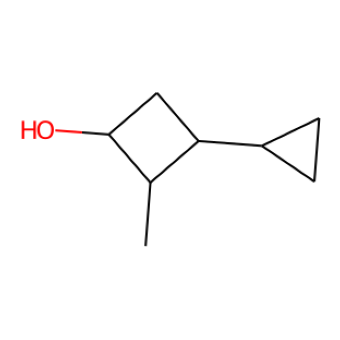

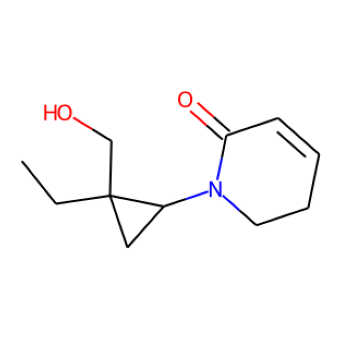

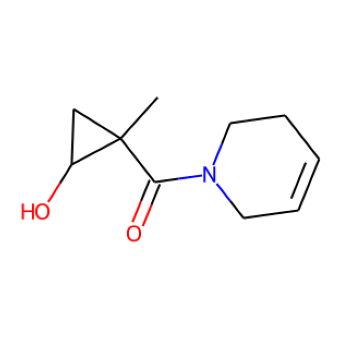

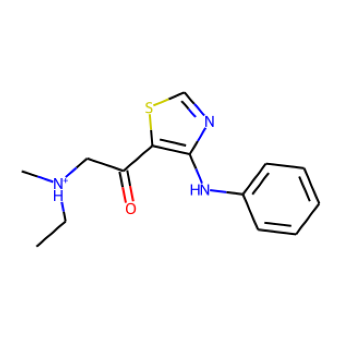

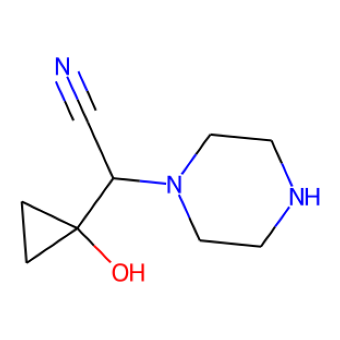

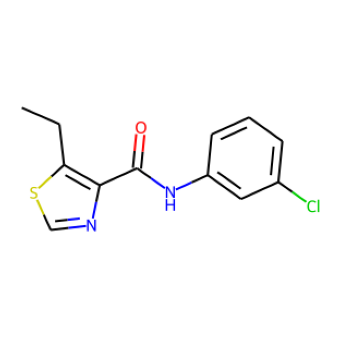

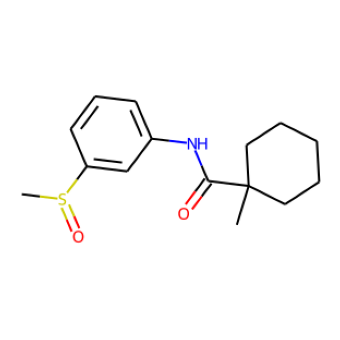

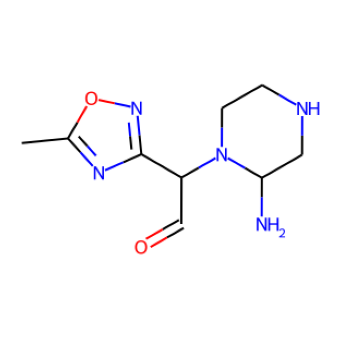

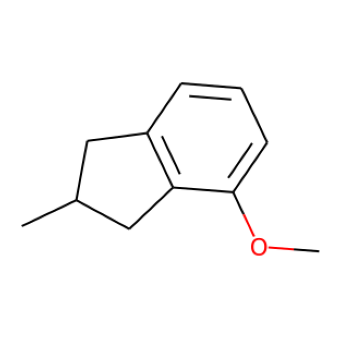

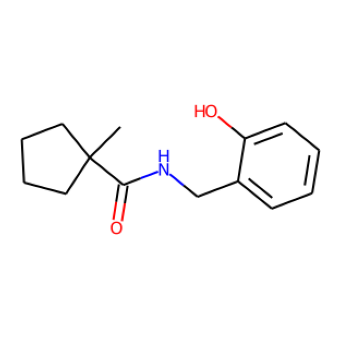

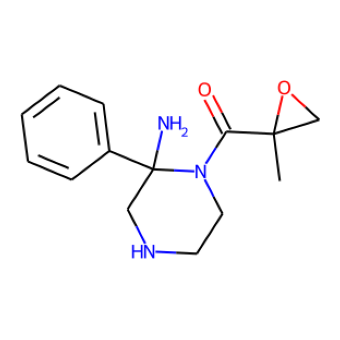

In [499]:
show_molecule("CC1C(O)CC1C1CC1")
for i in output_best:
    show_molecule(list_outputs[i])

In [511]:
outputs = get_similar(model, "OCC1C(C)C1", regressor, -5.721571)
list_outputs = list(outputs)
output_coeffs = regressor(model.encode_latent_mean(list_outputs))
output_best = torch.argsort(output_coeffs.flatten() - 5.721571)[-10:]

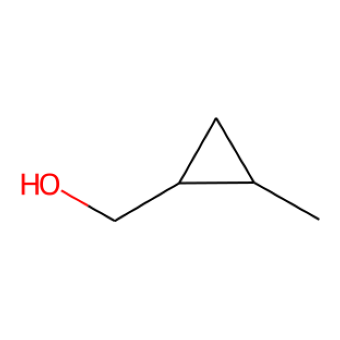

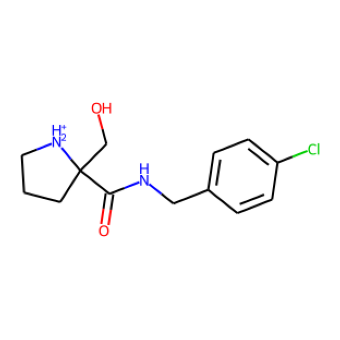

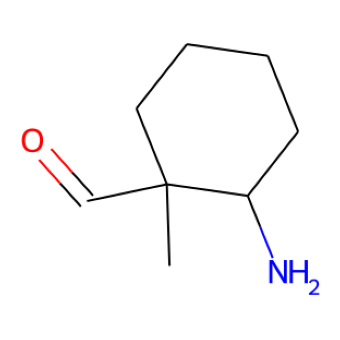

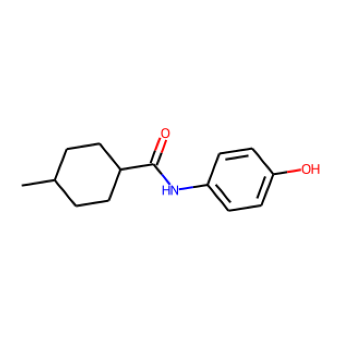

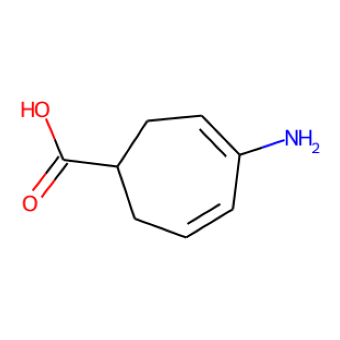

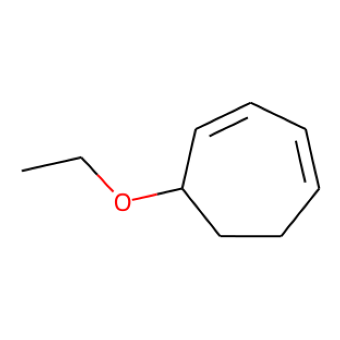

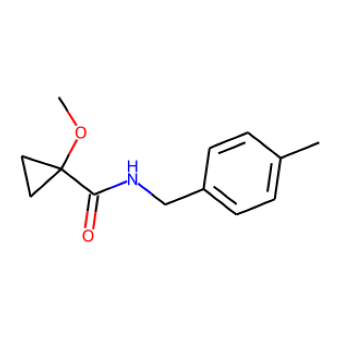

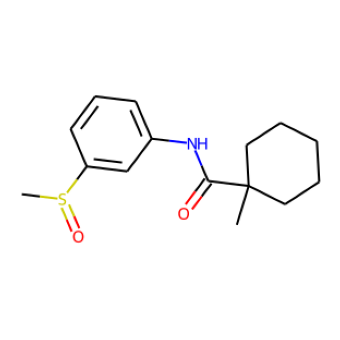

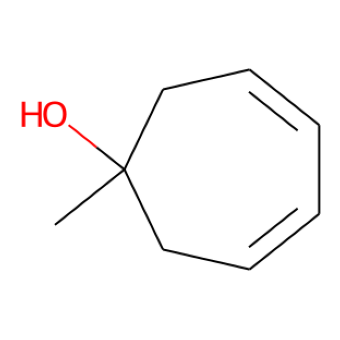

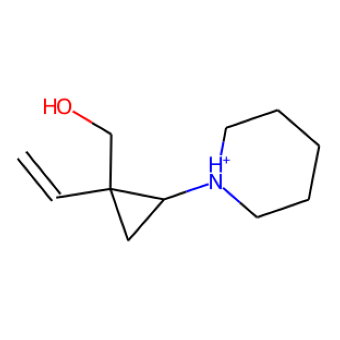

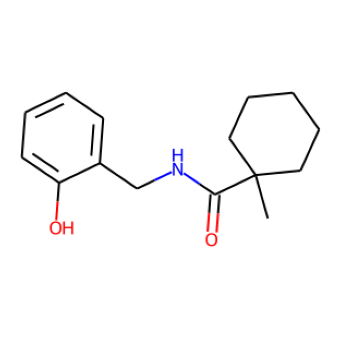

In [512]:
show_molecule("OCC1C(C)C1")
for i in output_best:
    show_molecule(list_outputs[i])